# Analyze time series data with wavelets

Uses pywavelets to perform wavelet analysis of time series data. Plots the results as a spectrogram

Check out the [pywavelets documentation](https://pywavelets.readthedocs.io/en/latest/index.html) to learn more!

To learn more about the basics conventional spectral analysis, you can check out one of my [lectures](https://github.com/dbheadley/DecodingTheBrain/blob/main/Week6/notes.ipynb)

For a more advanced and comprehensive discussion of spectral analysis, this [online textbook](https://brianmcfee.net/dstbook-site/content/intro.html) is exceptionally helpful and well illustrated.

In [1]:
import pywt
import pyabf
import scipy.signal as ss
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

## Wavelets for in vitro data (abf files)

### Load and plot the in vitro data
Here we load the in vitro data and downsample it. The reason is because the highest frequency we care about is 200 Hz, while the sample rate is 20 kHz. This can cause problems with constructing wavelets, so we downsample to 500 Hz, which gives us a nyquist frequency of 250 Hz and thus avoids aliasing problems.

Sample rate is 20000 Hz


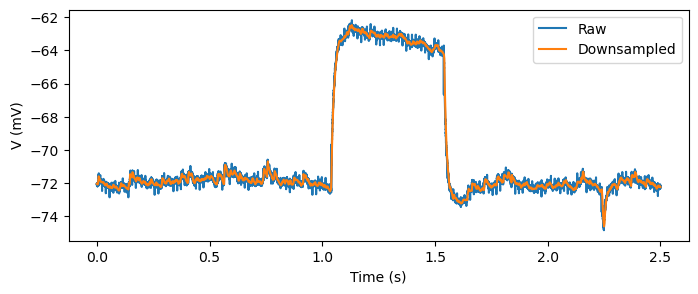

In [22]:
# Load ABF file
fpath = os.path.join(*['..','test_data', 'invitro', '21520000.abf'])
data = pyabf.ABF(fpath)

# Get recording info
fs = data.dataRate # sampling frequency
print("Sample rate is {} Hz".format(fs))

# Get sweep data
data.setSweep(sweepNumber=10, channel=2)
t = data.sweepX
v = data.sweepY

# downsample to 500 Hz
fs_ds = 500
v_ds = ss.decimate(v, int(fs/fs_ds), n=1, ftype='iir', zero_phase=True)
t_ds = np.linspace(0, len(v_ds)/fs_ds, len(v_ds))

# Plot sweep in time domain
fig, ax =plt.subplots(figsize=(8,3))
ax.plot(t, v, label='Raw')
ax.plot(t_ds, v_ds, label='Downsampled')
ax.set_ylabel('V (mV)')
ax.set_xlabel('Time (s)')
ax.legend()
plt.show()

### Calculate and plot wavelet spectrogram 

We almost always use the complex morlet wavelet, which allows us to easily get amplitude and phase information akin to what is returned by a conventional spectrogram.

When specifying the wavelet, you append two numbers to the name. The first is the center frequency, and the second is the bandwidth. I have chosen values for those parameters that are appropriate for the whole cell patch clamp recordings.

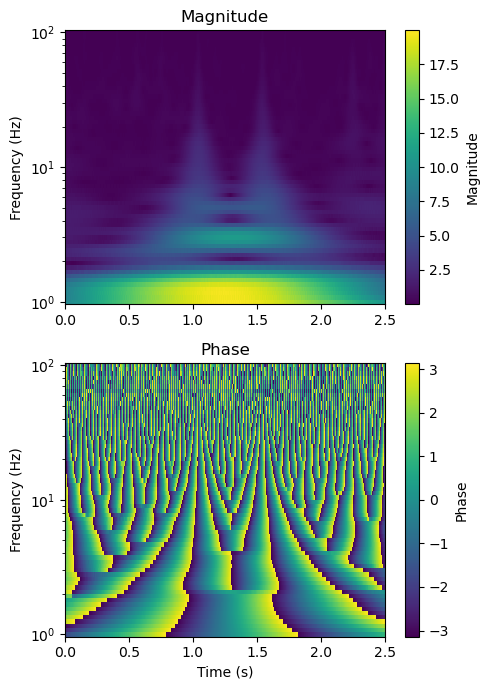

In [49]:
# Create a continuous wavelet transform object
# We will use the complex Morlet wavelet
w = pywt.ContinuousWavelet('cmor2.5-1.0')

# parameters for our spectral analysis
start_freq = 1 # Hz
end_freq = 100 # Hz
num_freqs = 64 # number of frequencies to analyze

# Create a range of frequencies
freqs = np.geomspace(1, 100, 64) # space frequencies logarithmically
scales = pywt.frequency2scale(w, freqs) * fs_ds # convert frequencies to scales

# Continuous wavelet transform
dt_ds = 1/fs_ds # time step in seconds
v_ds_offset = v_ds - np.mean(v_ds) # remove DC offset to minimize edge effects
cwtmatr, freqs = pywt.cwt(v_ds_offset, scales, w, sampling_period=dt_ds)

# get the magnitude and phase of the wavelet spectrogram
magnitude = np.abs(cwtmatr)
phase = np.angle(cwtmatr)

# Plot the magnitude and phase of the wavelet spectrogram
fig, ax = plt.subplots(2,1,figsize=(5,7))
mag_map = ax[0].pcolormesh(t_ds, freqs, magnitude, shading='auto')
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_yscale('log')
ax[0].set_title('Magnitude')
fig.colorbar(mag_map, ax=ax[0], label='Magnitude')
ph_map = ax[1].pcolormesh(t_ds, freqs, phase, shading='auto')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_yscale('log')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Phase')
fig.colorbar(ph_map, ax=ax[1], label='Phase')
fig.tight_layout()